In [2]:
import sys
import onnxruntime as ort
import numpy as np
from IPython.display import Image
from pathlib import Path
import matplotlib.pyplot as plt
import wandb
import os
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

sys.path.append('../')

In [3]:
from collections import Counter
api = wandb.Api()

bulk_runs = api.runs('nikebless/ebm-driving', filters={
        "$and": [{
        'created_at': {
            "$gt": '2022-09-28##'
            }
        }]
    }, 
    order='+created_at',
)

specific_run_ids = [
    # x3 pilotnet-mdn Old 1
    '3s5tapgz',
    '1bdlpf8d',
    '33smkc56',

    # x3 pilotnet-mdn New 1
    '274bkloa',
    '3nf72ili',
    'pt1zaaoq',

    # x3 pilotnet 1
    '13nkhdy1',
    'bxd5wtqk',
    'gwgmsh0e',

    # x3 classifier 0.2
    '2e3y0oce',
    '2ldsn0i0',
    'ouzghb1j',

    # x3 classifier 0.5
    '1t56cx3v',
    'd53rmg8e',
    '429pqx17',

    # x3 classifier 1
    '3g3wwx73',
    '3dvgzfda',
    '1uxvjkkw',

    # x3 ebm 0.2
    '1owxpr1x',
    'zie8x2vl',
    'zj7ugkj1',

    # x3 ebm 0.5
    '228inmtq',
    '2yofzwf0',
    '1b4hpefq',

    # x3 ebm 1
    '3ftnqxcb',
    '3dke382l',
    'kozacohh',
]
specific_runs = [api.run(f'nikebless/ebm-driving/{run_id}') for run_id in specific_run_ids]

models = []

for iterator in [bulk_runs, specific_runs]:
    for i, run in enumerate(iterator):
        if run.summary.get('epoch', None) is None: continue

        model_type = run.config.get('model_type')
        biased_mus = run.config.get('mdn_init_biases', False)
        if np.count_nonzero(biased_mus) == 0 or model_type == 'pilotnet': 
            biased_mus = False
        else:
            biased_mus = True
        dataset_size = run.config.get('dataset_proportion', 1)

        val_mae = run.history()['mae'].min()
        whiteness = run.history().sort_values(by='mae').iloc[0]['whiteness']

        model = (run.id, model_type, biased_mus, dataset_size, val_mae, whiteness)
        models.append(model)
        print(model)


('14klph7l', 'pilotnet-mdn', True, 0.5, 10.029207180694984, 329.0704345703125)
('yvyjlaih', 'pilotnet-mdn', True, 0.2, 11.096856069235852, 281.1494445800781)
('3n59fjvq', 'pilotnet-mdn', False, 0.5, 9.348881497311778, 158.29049682617188)
('1nbx1e35', 'pilotnet-mdn', False, 0.2, 10.536376282787568, 101.60249328613281)
('1ua8tl5f', 'pilotnet', False, 0.2, 10.916004913116746, 92.58895874023438)
('30ofcgv1', 'pilotnet', False, 0.5, 10.689991854968147, 125.07443237304688)
('3v23tg06', 'pilotnet', False, 0.5, 10.106329804939849, 186.30111694335938)
('1u4zay2v', 'pilotnet-mdn', False, 0.5, 9.897604314678434, 98.27059936523438)
('23n65v5n', 'pilotnet-mdn', True, 0.2, 11.238099471490376, 298.56683349609375)
('2hta8md0', 'pilotnet-mdn', True, 0.5, 9.288644050404393, 331.6133728027344)
('hkclym5p', 'pilotnet-mdn', False, 0.2, 11.252981108714117, 76.71823120117188)
('2ejzmxbz', 'pilotnet', False, 0.2, 10.43068273700337, 121.5796890258789)
('7pf5jmkx', 'pilotnet', False, 0.5, 10.204954273342388, 14

In [4]:
df = pd.DataFrame(models, columns=['run_id', 'model_type', 'biased_mus', 'dataset_size', 'val_mae', 'val_whiteness'])
df.groupby(['model_type', 'biased_mus', 'dataset_size']).mean()


val_mae  val_whiteness
model_type          biased_mus dataset_size                          
pilotnet            False      0.2           11.099449     115.008731
                               0.5           10.333759     153.735748
                               1.0            8.146564     155.928986
pilotnet-classifier False      0.2           14.817780     777.765045
                               0.5           12.934923     837.643784
                               1.0           10.711716     692.624308
pilotnet-ebm        False      0.2           12.027999     492.509659
                               0.5            9.646488     506.734268
                               1.0            8.797396     483.760986
pilotnet-mdn        False      0.2           10.807795      94.443405
                               0.5            9.796263     180.402547
                               1.0            8.987857     103.257645
                    True       0.2           11.280099     290.353383
                               0.5            9.945857     348.311300
                               1.0            9.047626     284.385773

In [ ]:
model_type_map = {
    'pilotnet': 'MAE',
    
}

pilotnet


,biased_mus,val_mae,val_whiteness,stds
dataset_size,,,,
0.2,0.0,11.099449,115.008731,19.962572
0.5,0.0,10.333759,153.735748,30.799480
1.0,0.0,8.146564,155.928986,24.419163


pilotnet-ebm


,biased_mus,val_mae,val_whiteness,stds
dataset_size,,,,
0.2,0.0,12.027999,492.509659,62.791958
0.5,0.0,9.646488,506.734268,39.876835
1.0,0.0,8.797396,483.760986,33.850926


pilotnet-classifier


,biased_mus,val_mae,val_whiteness,stds
dataset_size,,,,
0.2,0.0,14.817780,777.765045,194.854667
0.5,0.0,12.934923,837.643784,76.445600
1.0,0.0,10.711716,692.624308,78.724107


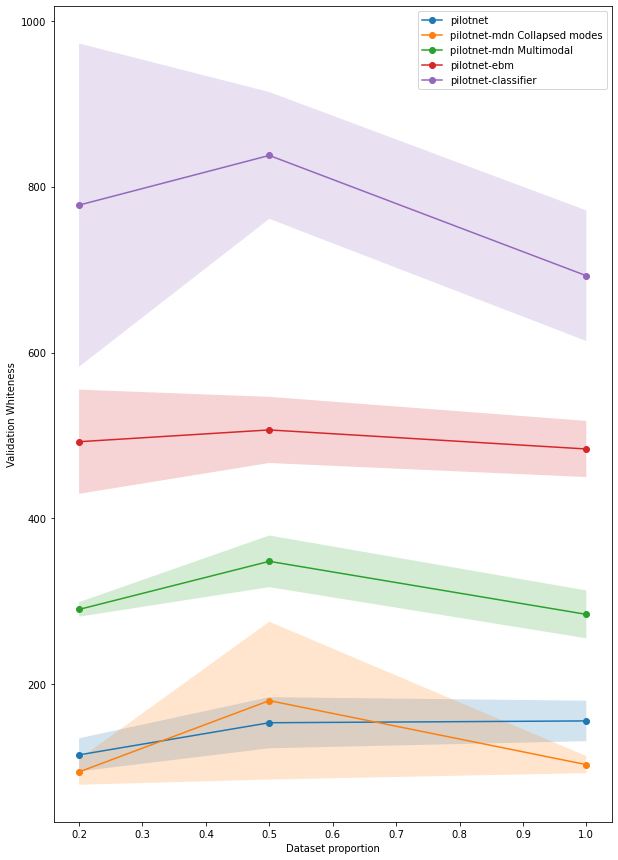

In [5]:
fix, ax = plt.subplots(figsize=(10, 15))

ax.set_xlabel('Dataset proportion')
ax.set_ylabel('Validation Whiteness')

for model_type in ['pilotnet', 'pilotnet-mdn', 'pilotnet-ebm', 'pilotnet-classifier']:
    if model_type == 'pilotnet-mdn':
        grouped_by_mus = df.groupby(['model_type', 'biased_mus', 'dataset_size'])

        means = grouped_by_mus.mean().loc[model_type]
        stds = grouped_by_mus.std().loc[model_type].fillna(0)
        means['stds'] = stds['val_whiteness']
        
        for is_multimodal, local_df in means.groupby(level=0):
            # print(f'{model_type} {is_multimodal}')
            local_df = local_df.reset_index(level=0, drop=True)
            # display(local_df)
            ax.plot(local_df.index, local_df['val_whiteness'], label=f'{model_type} {"Multimodal" if is_multimodal else "Collapsed modes"}', marker='o')
            ax.fill_between(local_df.index, local_df['val_whiteness'] - local_df['stds'], local_df['val_whiteness'] + local_df['stds'], alpha=0.2)
    else:
        print(f'{model_type}')
        means = df.groupby(['model_type', 'dataset_size']).mean().loc[model_type]
        stds = df.groupby(['model_type', 'dataset_size']).std().loc[model_type].fillna(0)
        means['stds'] = stds['val_whiteness']

        display(means)
        ax.plot(means.index, means['val_whiteness'], label=f'{model_type}', marker='o')
        ax.fill_between(means.index, means['val_whiteness'] - means['stds'], means['val_whiteness'] + means['stds'], alpha=0.2)


plt.legend()
plt.show()
plt.savefig('')

### Validation MAE

pilotnet


,val_mae,stds
dataset_size,,
0.2,11.280099,0.207456
0.5,9.945857,0.619755
1.0,9.047626,0.602382


pilotnet-ebm


,val_mae,whiteness,stds
dataset_size,,,
0.2,11.280099,290.353383,0.207456
0.5,9.945857,348.311300,0.619755
1.0,9.047626,284.385773,0.602382


pilotnet-classifier


,val_mae,whiteness,stds
dataset_size,,,
0.2,11.280099,290.353383,0.207456
0.5,9.945857,348.311300,0.619755
1.0,9.047626,284.385773,0.602382


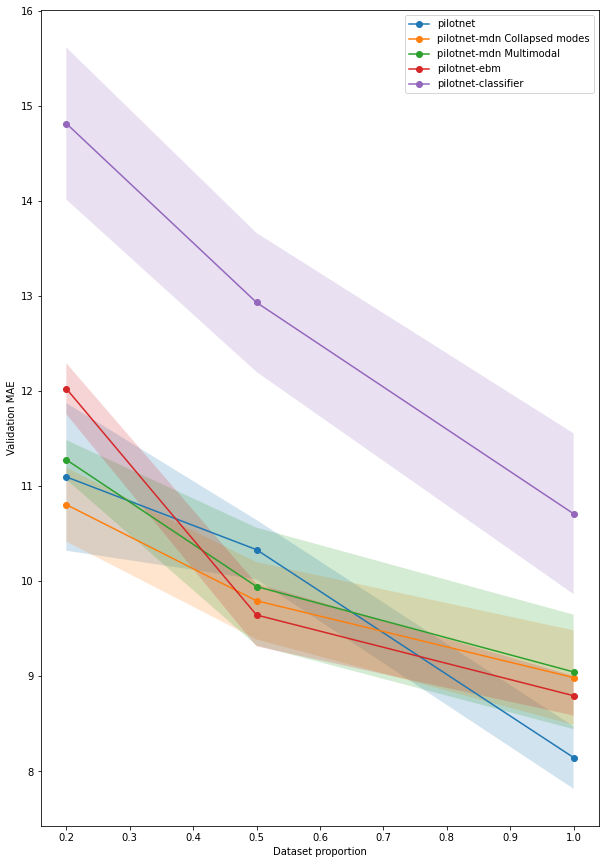

In [110]:
fix, ax = plt.subplots(figsize=(10, 15))

ax.set_xlabel('Dataset proportion')
ax.set_ylabel('Validation MAE')

for model_type in ['pilotnet', 'pilotnet-mdn', 'pilotnet-ebm', 'pilotnet-classifier']:
    if model_type == 'pilotnet-mdn':
        grouped_by_mus = df.groupby(['model_type', 'biased_mus', 'dataset_size'])

        means = grouped_by_mus.mean().loc[model_type]
        stds = grouped_by_mus.std().loc[model_type].fillna(0)
        means['stds'] = stds['val_mae']
        
        for is_multimodal, local_df in means.groupby(level=0):
            # print(f'{model_type} {is_multimodal}')
            local_df = local_df.reset_index(level=0, drop=True)
            # display(local_df)
            ax.plot(local_df.index, local_df['val_mae'], label=f'{model_type} {"Multimodal" if is_multimodal else "Collapsed modes"}', marker='o')
            ax.fill_between(local_df.index, local_df['val_mae'] - local_df['stds'], local_df['val_mae'] + local_df['stds'], alpha=0.2)
    else:
        print(f'{model_type}')
        means = df.groupby(['model_type', 'dataset_size']).mean().loc[model_type]
        stds = df.groupby(['model_type', 'dataset_size']).std().loc[model_type].fillna(0)
        means['stds'] = stds['val_mae']

        # local_df = df.groupby(['model_type', 'dataset_size']).mean().loc[model_type]
        display(local_df)
        ax.plot(means.index, means['val_mae'], label=f'{model_type}', marker='o')
        ax.fill_between(means.index, means['val_mae'] - means['stds'], means['val_mae'] + means['stds'], alpha=0.2)


plt.legend()
plt.show()